In [1]:
import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

In [2]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None, valsplit=0.2, train=True):
        self.img_labels = pd.read_csv(annotations_file)
        length = len(self.img_labels)
        if train:
            self.img_labels = self.img_labels[:int(length*(1-valsplit))]
        else:
            self.img_labels = self.img_labels[int(length*(1-valsplit)):]
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0] + '.jpg')
        image = read_image(img_path)
        label = torch.tensor([
            self.img_labels.iloc[idx, 1].astype(float),
            self.img_labels.iloc[idx, 2].astype(float),
            self.img_labels.iloc[idx, 3].astype(float),
            self.img_labels.iloc[idx, 4].astype(float)
        ])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [3]:
transformTr = T.Compose([
    T.Resize(size=(300, 300)),
    #T.AutoAugment(),
    T.ConvertImageDtype(torch.float)
    ])
    #T.Normalize((0,0,0), (255, 255, 255))])

transformVal = T.Compose([
    T.Resize(size=(300, 300)),
    T.ConvertImageDtype(torch.float)
    ])
    #T.Normalize((0,0,0), (255, 255, 255))])

batch_size = 30

trainset = CustomImageDataset(
    annotations_file='./plant/train.csv', 
    img_dir='./plant/train', 
    transform=transformTr,
    train=True)

trainloader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=batch_size, 
    shuffle=True,
    num_workers=0
)

valset = CustomImageDataset(
    annotations_file='./plant/train.csv', 
    img_dir='./plant/train', 
    transform=transformVal,
    train=False)

valloader = torch.utils.data.DataLoader(
    valset, 
    batch_size=batch_size, 
    shuffle=True,
    num_workers=0
)

In [4]:
i, l = valset.__getitem__(9)
print(i)

tensor([[[0.5961, 0.4745, 0.4235,  ..., 0.7333, 0.7373, 0.7333],
         [0.5529, 0.4667, 0.4235,  ..., 0.7373, 0.7373, 0.7333],
         [0.5216, 0.4549, 0.4157,  ..., 0.7255, 0.7373, 0.7373],
         ...,
         [0.2196, 0.2588, 0.1961,  ..., 0.3020, 0.3020, 0.2980],
         [0.3451, 0.2235, 0.2118,  ..., 0.2941, 0.2941, 0.2902],
         [0.2000, 0.1843, 0.1922,  ..., 0.2980, 0.2980, 0.3059]],

        [[0.5569, 0.4078, 0.3686,  ..., 0.8667, 0.8667, 0.8627],
         [0.5137, 0.4000, 0.3686,  ..., 0.8706, 0.8667, 0.8627],
         [0.4863, 0.3882, 0.3608,  ..., 0.8588, 0.8667, 0.8667],
         ...,
         [0.3765, 0.4196, 0.3451,  ..., 0.4235, 0.4235, 0.4196],
         [0.5059, 0.3765, 0.3647,  ..., 0.4157, 0.4157, 0.4118],
         [0.3490, 0.3451, 0.3451,  ..., 0.4235, 0.4235, 0.4118]],

        [[0.5490, 0.3686, 0.3333,  ..., 0.5294, 0.5255, 0.5216],
         [0.5059, 0.3608, 0.3333,  ..., 0.5333, 0.5255, 0.5216],
         [0.4784, 0.3490, 0.3255,  ..., 0.5176, 0.5255, 0.

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 64, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 5)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(128, 128, 5)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.dense1 = nn.Linear(15*15*128, 512)
        self.dense2 = nn.Linear(512, 4)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        x = torch.flatten(x,1)
        x = self.dropout(x)
        x = F.relu(self.dense1(x))
        x = self.dense2(x)
        return x

net = ConvNet()

In [6]:
i = torch.reshape(i, (1,3,300,300))
pre = net(i)
print(pre)
print(torch.max(pre.data, 1))

tensor([[ 0.0259, -0.0220, -0.0461,  0.0238]], grad_fn=<AddmmBackward0>)
torch.return_types.max(
values=tensor([0.0259]),
indices=tensor([0]))


In [7]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.RMSprop(net.parameters(), lr=1e-5, momentum=0.9)
optimizer = optim.Adam(net.parameters())

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

ConvNet(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (dense1): Linear(in_features=28800, out_features=512, bias=True)
  (dense2): Linear(in_features=512, out_features=4, bias=True)
)

In [10]:
epoch_num = 10
for epoch in range(epoch_num):
    tr_loss = 0.0
    tr_correct = 0.0
    i = 0
    val_loss = 0.0
    val_correct = 0.0
    j = 0
    '''
    with tqdm(trainloader, unit="batch", ascii=True) as tepoch:
        for data in tepoch:
            i = i + 1
            tepoch.set_description(f"Epock {epoch + 1}")
            inputs, labels = data
            labels = labels.to(device)
            inputs = inputs.to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            predicted = torch.max(outputs.data, 1)
            tr_correct += (predicted[1] == torch.max(labels.data, 1)[1]).sum().item()
            #tr_correct += (outputs == labels).sum().item()

            tr_loss += loss.item()
            tepoch.set_postfix(tr_loss=loss.item(), tr_acc=tr_correct/i/batch_size)
            '''
    for data in trainloader:
        i = i + 1
        #tepoch.set_description(f"Epock {epoch + 1}")
        inputs, labels = data
        labels = labels.to(device)
        inputs = inputs.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        predicted = torch.max(outputs.data, 1)
        tr_correct += (predicted[1] == torch.max(labels.data, 1)[1]).sum().item()
        #tr_correct += (outputs == labels).sum().item()

        tr_loss += loss.item()
        if i%10 == 9:
            print(tr_loss/10)
            tr_loss = 0

        '''
        with torch.no_grad():
            for val_data in valloader:
                j = j + 1
                val_input, val_label = val_data
                val_input = val_input.to(device)
                val_label = val_label.to(device)
                val_output = net(val_input)
                vloss = criterion(val_output, val_label)
                val_loss += vloss
                predicted = torch.max(val_output.data, 1)
                val_correct += (predicted[1] == torch.max(val_label.data, 1)[1]).sum().item()
                #val_correct += (val_output == val_label).sum().item()
    print(f"val_loss={val_loss/j}, val_acc={val_correct/j/batch_size}")
    '''

1.1557582221428553
1.280280054608981
1.2770111393928527
1.2759876461823783
1.2372756940623124
1.1395550962289174
1.2288572776317597
1.2703159709771474
1.2205591954787574


KeyboardInterrupt: 

In [ ]:
for epoch in range(10):  # loop over the dataset multiple times
    i=0

    running_loss = 0.0
    for data in trainloader:
        # get the inputs; data is a list of [inputs, labels]
        i=i+1

        inputs, labels = data
        labels = labels.to(device)
        inputs = inputs.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

print('Finished Training')

[1,    10] loss: 0.327
[1,    20] loss: 0.450
[1,    30] loss: 0.359
[1,    40] loss: 0.524
[1,    50] loss: 0.386
[2,    10] loss: 0.276
[2,    20] loss: 0.375


KeyboardInterrupt: 

In [ ]:
itr1 = iter(valloader)
image, label = itr1.next()
print(label.shape)

torch.Size([30, 4])


tensor([[0.5098, 0.4941, 0.5020, 0.4941, 0.4941],
        [0.5137, 0.5059, 0.4902, 0.4863, 0.4863],
        [0.5137, 0.5020, 0.4941, 0.4902, 0.4784],
        [0.5176, 0.5098, 0.5020, 0.4902, 0.4784],
        [0.5216, 0.5098, 0.4902, 0.4863, 0.4824]])


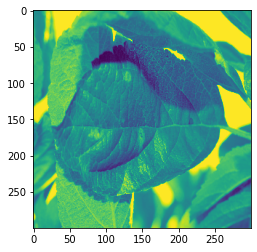

In [ ]:
itr = iter(trainloader)
input, output = itr.next()
print(input[5,1, :5,:5])
import matplotlib.pyplot as plt
plt.imshow(input[5,1,:,:]*255)
plt.show()

In [ ]:
print(input[1,1,:5,:5])

tensor([[0.2000, 0.1373, 0.0941, 0.1059, 0.1216],
        [0.1725, 0.1490, 0.1294, 0.0902, 0.1059],
        [0.1804, 0.1490, 0.1451, 0.0902, 0.1059],
        [0.2196, 0.1490, 0.1294, 0.1922, 0.1020],
        [0.3529, 0.2196, 0.0902, 0.1137, 0.1137]])


In [ ]:
import pandas as pd
img_labels = pd.read_csv('./plant/train.csv')

In [ ]:
import torch
a = img_labels
idx = 1
b = [a.iloc[idx,1],
a.iloc[idx,2],
a.iloc[idx,3],
a.iloc[idx,4],
]
c = torch.tensor(b)

In [ ]:
print(c)

tensor([0, 1, 0, 0])
